**The example bellow uses Obspy to fix bad trace header information in SEGY file**

The segyfile bellow had equal values of cmpx and cmpy for subsequente traces. 
The coordinates just changed at every 2 traces. 

**OBSPY** was used to get just the not repeated values and than was used a linear function to interpolate new values in between creating a new SEGY file capable of being loaded in ordinary G&G sofware.

In [7]:
%cd data
stream = utils.obspy.read('R0003_BAHIA_SUL.0231-1496.MIG_FIN.93.sgy', format="SEGY")

(bookmark:data) -> /hd0/data
/hd0/data


In [3]:
%cd /media/andre/KINGDRE/Bahia_Sul
from obspy.segy.core import readSEGY
section = readSEGY('R0003_BAHIA_SUL.0232-0157.MIG_FIN.35.sgy', unpack_trace_headers=True)

/media/andre/KINGDRE/Bahia_Sul


In [4]:
import obspy.segy.header as segyheaders
segyheaders.TRACE_HEADER_FORMAT # trace header keys per byte definition, index zero based (%!definition table!%)
section.stats.textual_file_header  # from the segy loaded
section.stats.binary_file_header.keys() # from the segy loaded

['binary_gain_recovered',
 'line_number',
 'number_of_auxiliary_traces_per_ensemble',
 'sample_interval_in_microseconds_of_original_field_recording',
 'vibratory_polarity_code',
 'taper_type',
 'number_of_samples_per_data_trace',
 'ensemble_fold',
 'reel_number',
 'trace_sorting_code',
 'sweep_frequency_at_start',
 'sample_interval_in_microseconds',
 'sweep_frequency_at_end',
 'measurement_system',
 'seg_y_format_revision_number',
 'number_of_data_traces_per_ensemble',
 'unassigned_1',
 'unassigned_2',
 'data_sample_format_code',
 'sweep_type_code',
 'impulse_signal_polarity',
 'sweep_trace_taper_length_in_ms_at_start',
 'trace_number_of_sweep_channel',
 'number_of_samples_per_data_trace_for_original_field_recording',
 'job_identification_number',
 'vertical_sum_code',
 'amplitude_recovery_method',
 'correlated_data_traces',
 'sweep_trace_taper_length_in_ms_at_end',
 'number_of_3200_byte_ext_file_header_records_following',
 'fixed_length_trace_flag',
 'endian',
 'sweep_length']

In [5]:
print section

2057 Trace(s) in Stream:

Seq. No. in line:    1 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:11.996000Z | 250.0 Hz, 3000 samples
...
(2055 other traces)
...
Seq. No. in line: 2057 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:11.996000Z | 250.0 Hz, 3000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


In [16]:
import numpy, pylab
from matplotlib import pyplot
from scipy.interpolate import InterpolatedUnivariateSpline
from obspy.segy.core import readSEGY
# getting just not repeated coordinate values
ntr = len(section)
sx = numpy.zeros(1)
sy = numpy.zeros(1)
trc = numpy.zeros(1) # trace index
cdpx = numpy.zeros(ntr)
cdpy = numpy.zeros(ntr)
# 181, 185 cdpx, cdpy (first point allways in)
cdpx[0] = section[0].stats.segy.trace_header.x_coordinate_of_ensemble_position_of_this_trace
cdpy[0] = section[0].stats.segy.trace_header.y_coordinate_of_ensemble_position_of_this_trace
sx[0] = cdpx[0] 
sy[0] = cdpy[0]
trc[0] = 0
for i in numpy.arange(1, ntr):
    cdpx[i] = section[i].stats.segy.trace_header.x_coordinate_of_ensemble_position_of_this_trace
    cdpy[i] = section[i].stats.segy.trace_header.y_coordinate_of_ensemble_position_of_this_trace
    if (cdpx[i] != cdpx[i-1]) or (cdpy[i] != cdpy[i-1]) : # just in case (x, y) == (x, y) ignore
        sx = numpy.append(sx, cdpx[i])    
        sy = numpy.append(sy, cdpy[i])
        trc = numpy.append(trc, i)
pylab.rcParams['figure.figsize'] = 12, 6 
print len(trc), len(sx), len(sy), len(cdpx), len(cdpy), 
pyplot.plot(trc[:30], sx[:30], '^w', numpy.arange(trc[30]), cdpx[:trc[30]], '+')
pyplot.legend(['not duplicated', 'all'], loc='best')
pyplot.show()

1029 1029 1029 2057 2057


-c:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [17]:
from scipy.interpolate import InterpolatedUnivariateSpline
x = trc # not duplicated indexes
y = sx # not duplicated coordinates
flinear = InterpolatedUnivariateSpline(x, y, bbox=[-3, ntr+2], k=1) # linear iterp function case where spline degree k=1
xnew = numpy.arange(0, ntr, 1) # indexes of all traces 
pyplot.plot(trc[:30], sx[:30], '^w', numpy.arange(trc[30]), cdpx[:trc[30]], '+', xnew[:trc[30]], flinear(xnew[:trc[30]]), 'k.')
pyplot.legend(['not duplicated', 'all', 'corrected'], loc='best')
pyplot.show()

-c:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
-c:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
-c:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [196]:
from scipy.interpolate import InterpolatedUnivariateSpline
from obspy.segy.core import readSEGY
section = readSEGY('R0003_BAHIA_SUL.0231-1496.MIG_FIN.93.sgy', unpack_trace_headers=True)
# getting just not repeated coordinate values sx, sy
ntr = len(section) # number of traces
sx = numpy.zeros(1) 
sy = numpy.zeros(1)
trc = numpy.zeros(1) # trace index of not duplicated traces
cdpx = numpy.zeros(ntr) # original x coordinate
cdpy = numpy.zeros(ntr) # original y coordinate
# bytes (181, 185) (cdpx, cdpy) (first point allways in)
cdpx[0] = section[0].stats.segy.trace_header.x_coordinate_of_ensemble_position_of_this_trace
cdpy[0] = section[0].stats.segy.trace_header.y_coordinate_of_ensemble_position_of_this_trace
sx[0] = cdpx[0] 
sy[0] = cdpy[0]
trc[0] = 0
for i in numpy.arange(1, ntr): # get just the not duplicated coordinates
    cdpx[i] = section[i].stats.segy.trace_header.x_coordinate_of_ensemble_position_of_this_trace
    cdpy[i] = section[i].stats.segy.trace_header.y_coordinate_of_ensemble_position_of_this_trace
    if (cdpx[i] != cdpx[i-1]) or (cdpy[i] != cdpy[i-1]) : # just in case (x, y) == (x, y) ignore
        sx = numpy.append(sx, cdpx[i])    
        sy = numpy.append(sy, cdpy[i])
        trc = numpy.append(trc, i)
#trc (not duplicated indexes = x)
#sx, sy not duplicated coordinates
flinearsx = InterpolatedUnivariateSpline(trc, sx, bbox=[-3, ntr+2], k=1) # linear iterp function on xcoordinate ; x is trace index
flinearsy = InterpolatedUnivariateSpline(trc, sy, bbox=[-3, ntr+2], k=1) # linear iterp function on ycoordinate ; x is trace index
# (to enable linear extrapolation that interp1 doesn't do) spline=linear iterp function case where spline degree k=1
# uses limits of extrapolation +3 traces before and after
for trace_index in numpy.arange(0, ntr, 1): # interpolate for all trace indexes, changing the trace headers on bytes (73, 77)    
    section[trace_index].stats.segy.trace_header.source_coordinate_x = int(flinearsx(trace_index))
    section[trace_index].stats.segy.trace_header.source_coordinate_y = int(flinearsy(trace_index))      
    
section.write('R0003_BAHIA_SUL.0231-1496.MIG_FIN.93B.sgy', format='SEGY')

3485 3485 3485 3485 3485


-c:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


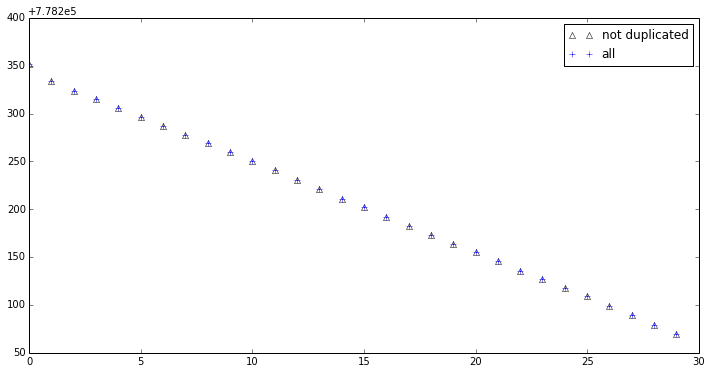

In [203]:
# QC of the script
ntr = len(section)
sx = numpy.zeros(1)
sy = numpy.zeros(1)
trc = numpy.zeros(1) # trace index
cdpx = numpy.zeros(ntr)
cdpy = numpy.zeros(ntr)
# 181, 185 cdpx, cdpy (first point allways in)
cdpx[0] = section[0].stats.segy.trace_header.source_coordinate_x
cdpy[0] = section[0].stats.segy.trace_header.source_coordinate_x
sx[0] = cdpx[0] 
sy[0] = cdpy[0]
trc[0] = 0
for i in numpy.arange(1, ntr):
    cdpx[i] = section[i].stats.segy.trace_header.source_coordinate_x
    cdpy[i] = section[i].stats.segy.trace_header.source_coordinate_x
    if (cdpx[i] != cdpx[i-1]) or (cdpy[i] != cdpy[i-1]) : # just in case (x, y) == (x, y) ignore
        sx = numpy.append(sx, cdpx[i])    
        sy = numpy.append(sy, cdpy[i])
        trc = numpy.append(trc, i)
pylab.rcParams['figure.figsize'] = 12, 6 
print len(sx), len(cdpx), len(sy), len(cdpy), len(trc)
pyplot.plot(trc[:30], sx[:30], '^w', numpy.arange(trc[30]), cdpx[:trc[30]], '+')
pyplot.legend(['not duplicated', 'all'], loc='best')

In [157]:
segyheaders.TRACE_HEADER_FORMAT 

[[4, 'trace_sequence_number_within_line', False, 0],
 [4, 'trace_sequence_number_within_segy_file', False, 4],
 [4, 'original_field_record_number', False, 8],
 [4, 'trace_number_within_the_original_field_record', False, 12],
 [4, 'energy_source_point_number', False, 16],
 [4, 'ensemble_number', False, 20],
 [4, 'trace_number_within_the_ensemble', False, 24],
 [2, 'trace_identification_code', False, 28],
 [2, 'number_of_vertically_summed_traces_yielding_this_trace', False, 30],
 [2, 'number_of_horizontally_stacked_traces_yielding_this_trace', False, 32],
 [2, 'data_use', False, 34],
 [4,
  'distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group',
  False,
  36],
 [4, 'receiver_group_elevation', False, 40],
 [4, 'surface_elevation_at_source', False, 44],
 [4, 'source_depth_below_surface', False, 48],
 [4, 'datum_elevation_at_receiver_group', False, 52],
 [4, 'datum_elevation_at_source', False, 56],
 [4, 'water_depth_at_source', False, 60],
 [4, 'water_depth_at_group